In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os


In [8]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim=784, h_dim=200, z_dim=20):
        super().__init__()
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)
        self.relu = nn.ReLU()
    
    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu = self.hid_2mu(h)
        sigma = self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, sigma


In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
BATCH_SIZE = 128
NUM_EPOCHS = 10
LR = 3e-4

dataset = datasets.MNIST(
    root="dataset/",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCELoss(reduction="sum")


In [10]:
from tqdm import tqdm

for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for x, _ in loop:
        x = x.view(-1, INPUT_DIM).to(DEVICE)
        x_recon, mu, sigma = model(x)

        recon_loss = loss_fn(x_recon, x)
        kl_div = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        loss = recon_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())


Epoch 10/10: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s, loss=1.13e+4]


In [11]:
def inference(model, dataset, digit, num_examples=1):
    model.eval()
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    mu, sigma = model.encode(images[digit].view(1, -1).to(DEVICE))
    for i in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decode(z).view(-1, 1, 28, 28)
        os.makedirs("results", exist_ok=True)
        save_image(out, f"results/generated_{digit}_ex{i}.png")

for i in range(10):
    inference(model, dataset, i)


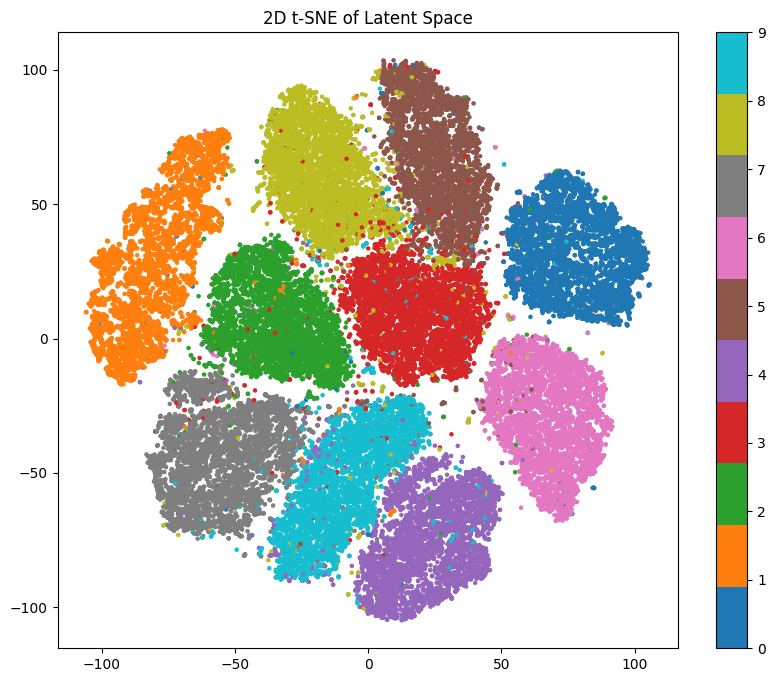

In [12]:
model.eval()
all_z = []
all_labels = []

for x, y in DataLoader(dataset, batch_size=512):
    x = x.view(-1, 784).to(DEVICE)
    with torch.no_grad():
        mu, _ = model.encode(x)
    all_z.append(mu.cpu())
    all_labels.extend(y.numpy())

z_concat = torch.cat(all_z).numpy()
tsne = TSNE(n_components=2)
z_2d = tsne.fit_transform(z_concat)

plt.figure(figsize=(10, 8))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=all_labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("2D t-SNE of Latent Space")
plt.savefig("results/latent_space.png")
plt.show()
